In [1]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [3]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])

print(modal_mineralogy[1])


[0.27453254 0.40124204 0.24993859 0.02509231 0.00454988 0.04464465]


In [4]:
par_rock = 1e9
data1 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 46.1328 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 146.7812 seconds
Counting interfaces...  Done in 1.0014 seconds
Correcting interface arrays for consistency...
too much Q 10
too few P -1
too few K -3
too few B -3
too few O -1
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A| Done in 6.2155 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 44.3434 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 90.4951 seconds
Counting interfaces...  Done in 0.9762 seconds
Correcting interface arrays for consistency...

[2. 3. 4. 5.]


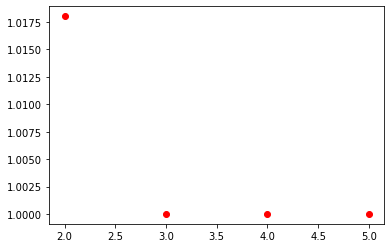

In [5]:
x = np.array([100,1000,10000,100000])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4])
logar = np.log10(x)
print(logar)

plt.plot(logar,y,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.9512 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 22.0391 seconds
Counting interfaces...  Done in 0.0958 seconds
Correcting interface arrays for consistency...
too much Q 4
too few P -2
all good K 0
too few B -1
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.6282 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 4.8253 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 9.2710 seconds
Counting interfaces...  Done in 0.0942 seconds
Correcting interface arrays for consistency...
too 

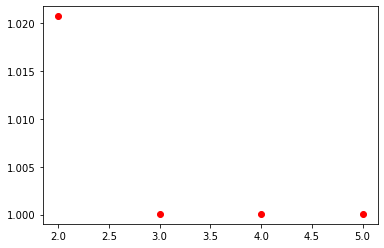

In [6]:
par_rock = 1e8
data1 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock
x = np.array([100,1000,10000,100000])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4])
logar = np.log10(x)
print(logar)

plt.plot(logar,y,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.6910 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.7561 seconds
Counting interfaces...  Done in 0.0093 seconds
Correcting interface arrays for consistency...
too much Q 7
too few P -4
too few K -1
all good B 0
too few O -2
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.0503 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.9397 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.7531 seconds
Counting interfaces...  Done in 0.0082 seconds
Correcting interface arrays for consistency...
too m

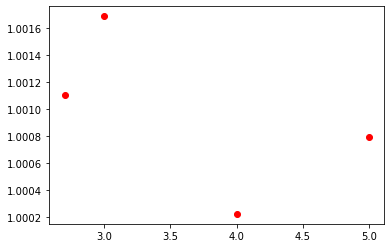

In [7]:
par_rock = 1e7
data1 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 500, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock
x = np.array([500,1000,10000,100000])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4])
logar = np.log10(x)
print(logar)

plt.plot(logar,y,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.4568 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.8039 seconds
Counting interfaces...  Done in 0.0090 seconds
Correcting interface arrays for consistency...
too much Q 3
too few P -2
too much K 1
all good B 0
all good O 0
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.0541 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.9494 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.8060 seconds
Counting interfaces...  Done in 0.0090 seconds
Correcting interface arrays for consistency...
too m

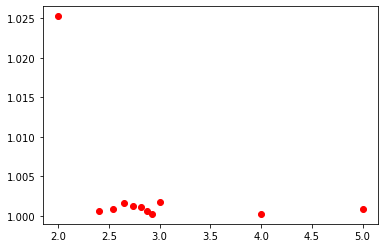

In [8]:
par_rock = 1e7
data1 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock
data5 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 250, discretization_init = False, timed = True)
datapunt5 = np.sum(data5.simulated_volume)/par_rock
data6 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 350, discretization_init = False, timed = True)
datapunt6 = np.sum(data6.simulated_volume)/par_rock
data7 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 450, discretization_init = False, timed = True)
datapunt7 = np.sum(data7.simulated_volume)/par_rock
data8 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 550, discretization_init = False, timed = True)
datapunt8 = np.sum(data8.simulated_volume)/par_rock
data9 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 650, discretization_init = False, timed = True)
datapunt9 = np.sum(data9.simulated_volume)/par_rock
data10 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 750, discretization_init = False, timed = True)
datapunt10 = np.sum(data10.simulated_volume)/par_rock
data11 = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate = 850, discretization_init = False, timed = True)
datapunt11 = np.sum(data11.simulated_volume)/par_rock



x = np.array([100,1000,10000,100000,250,350,450,550,650,750,850])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4, datapunt5, datapunt6 ,datapunt7 ,datapunt8, datapunt9, datapunt10, datapunt11])
logar = np.log10(x)
print(logar)

plt.plot(logar,y,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.0852 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.2426 seconds
Counting interfaces...  Done in 0.0026 seconds
Correcting interface arrays for consistency...
too few Q -4
too much P 1
too much K 1
too much B 2
too few O -1
too much A 1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.0133 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.2675 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.1652 seconds
Counting interfaces...  Done in 0.0017 seconds
Correcting interface arrays for consistency...
too m

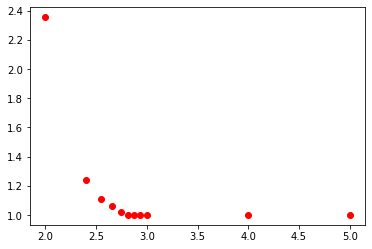

In [10]:
par_rock = 1e7

data1 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 100, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock
data5 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 250, discretization_init = False, timed = True)
datapunt5 = np.sum(data5.simulated_volume)/par_rock
data6 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 350, discretization_init = False, timed = True)
datapunt6 = np.sum(data6.simulated_volume)/par_rock
data7 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 450, discretization_init = False, timed = True)
datapunt7 = np.sum(data7.simulated_volume)/par_rock
data8 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 550, discretization_init = False, timed = True)
datapunt8 = np.sum(data8.simulated_volume)/par_rock
data9 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 650, discretization_init = False, timed = True)
datapunt9 = np.sum(data9.simulated_volume)/par_rock
data10 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 750, discretization_init = False, timed = True)
datapunt10 = np.sum(data10.simulated_volume)/par_rock
data11 = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate = 850, discretization_init = False, timed = True)
datapunt11 = np.sum(data11.simulated_volume)/par_rock



x = np.array([100, 1000,10000,100000,250,350,450,550,650,750,850])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4, datapunt5, datapunt6 ,datapunt7 ,datapunt8, datapunt9, datapunt10, datapunt11])
logar = np.log10(x)
print(y)

print(logar)

plt.plot(logar,y,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.5399 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.3073 seconds
Counting interfaces...  Done in 0.0361 seconds
Correcting interface arrays for consistency...
too much Q 12
too few P -4
too few K -4
too few B -2
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2332 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.4995 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.0916 seconds
Counting interfaces...  Done in 0.0334 seconds
Correcting interface arrays for consistency...
too 

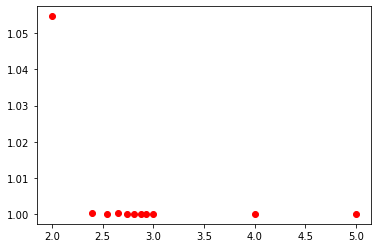

In [12]:
par_rock = 1e8

data1 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 100, discretization_init = False, timed = True)
datapunt1 = np.sum(data1.simulated_volume)/par_rock
data2 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 1000, discretization_init = False, timed = True)
datapunt2 = np.sum(data2.simulated_volume)/par_rock
data3 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 10000, discretization_init = False, timed = True)
datapunt3 = np.sum(data3.simulated_volume)/par_rock
data4 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 100000, discretization_init = False, timed = True)
datapunt4 = np.sum(data4.simulated_volume)/par_rock
data5 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 250, discretization_init = False, timed = True)
datapunt5 = np.sum(data5.simulated_volume)/par_rock
data6 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 350, discretization_init = False, timed = True)
datapunt6 = np.sum(data6.simulated_volume)/par_rock
data7 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 450, discretization_init = False, timed = True)
datapunt7 = np.sum(data7.simulated_volume)/par_rock
data8 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 550, discretization_init = False, timed = True)
datapunt8 = np.sum(data8.simulated_volume)/par_rock
data9 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 650, discretization_init = False, timed = True)
datapunt9 = np.sum(data9.simulated_volume)/par_rock
data10 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 750, discretization_init = False, timed = True)
datapunt10 = np.sum(data10.simulated_volume)/par_rock
data11 = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate = 850, discretization_init = False, timed = True)
datapunt11 = np.sum(data11.simulated_volume)/par_rock



x = np.array([100, 1000,10000,100000,250,350,450,550,650,750,850])

y = np.array([datapunt1, datapunt2, datapunt3, datapunt4, datapunt5, datapunt6 ,datapunt7 ,datapunt8, datapunt9, datapunt10, datapunt11])
logar = np.log10(x)
print(y)

print(logar)

plt.plot(logar,y,'ro')